## MAPK transient vs. sustained EGF stimulus
*Nathaniel Linden - October 2023*

In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode

sys.path.append("./models/")
from hatakeyama_2003 import *


from utils import *

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@jax.jit
def solve_traj_local(model_dfrx_ode, y0, params, t1, ERK_indices, event_rtol=1e-6, event_atol=1e-5):
    """ simulates a model over the specified time interval and returns the 
    calculated values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, 
        t1, 
        dt0, 
        tuple(y0), 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        # saveat=saveat,
        args=params,
        max_steps=600000,
        throw=False,)
    
    return jnp.sum(jnp.array(sol.ys)[ERK_indices, :], axis=0), sol.ts

In [3]:
# get training and testing data
inputs, data = load_data('../../results/MAPK/HF_96_synthetic_data.csv')
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

model_info = json.load(open('./param_est/model_info.json', 'r'))
HK_2003_info = model_info['hatakeyama_2003']

idata,_ = load_smc_samples_to_idata('../../results/MAPK/param_est/HF96_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
idata_traj,_ = load_smc_samples_to_idata('../../results/MAPK/param_est/HF96_traj_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')

model = hatakeyama_2003(transient=False)
p_dict, _ = model.get_nominal_params()
y0_dict, y0 = model.get_initial_conditions()

In [4]:
inputs_native_units = inputs * HK_2003_info['EGF_conversion_factor']
# get the EGF index and ERK indices
state_names = list(y0_dict.keys())
EGF_idx = state_names.index(HK_2003_info['input_state'])
ERK_indices = [state_names.index(s) for s in HK_2003_info['ERK_states'].split(',')]

# make initial conditions that reflect the inputs
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)

nsamples = 40
param_samples = get_param_subsample(idata, nsamples, p_dict)
param_samples_traj = get_param_subsample(idata_traj, nsamples, p_dict)

In [5]:
sols = []
for param in param_samples:
    temp = []
    for input in y0_EGF_ins:
        sol, ts = solve_traj_local(diffrax.ODETerm(model), input, param, jnp.inf, ERK_indices)
        temp.append((sol, ts))
    sols.append(temp)

sols_traj = []
for param in param_samples_traj:
    temp = []
    for input in y0_EGF_ins:
        sol, ts = solve_traj_local(diffrax.ODETerm(model), input, param, jnp.inf, ERK_indices)
        temp.append((sol, ts))
    sols_traj.append(temp)

In [6]:
normalized = [np.array([np.array(s[0]) for s in sol]) for sol in sols_traj]
normalized = np.squeeze(np.array(normalized))

Text(0, 0.5, 'ERK (normalized)')

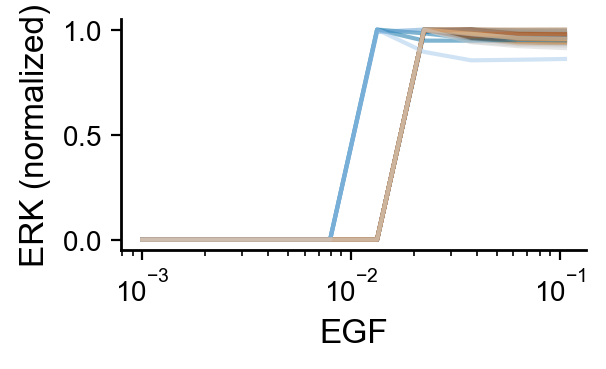

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

for sol in normalized:
    ax.plot(inputs, sol/np.max(sol), alpha=0.5,)

ax.set_xscale('log')
ax.set_xlabel('EGF')
ax.set_ylabel('ERK (normalized)')

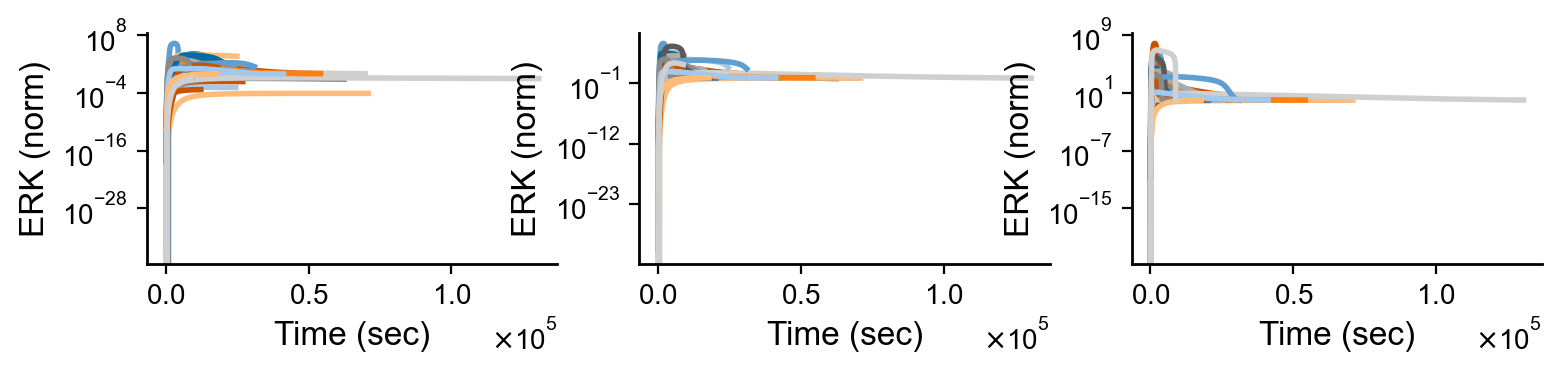

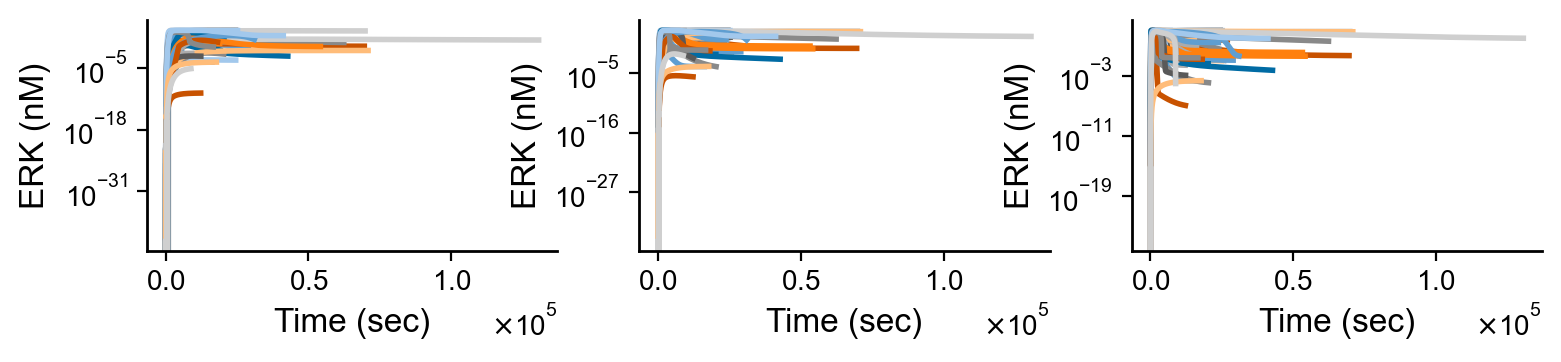

In [8]:
fig0, ax0 = plt.subplots(1,3, figsize=(9, 1.5))
fig1, ax1 = plt.subplots(1,3, figsize=(9, 1.5))

for idx_interest in range(40):
    max_time = np.max([s[1] for s in np.array(sols[idx_interest])[[0,3,9]]])

    traj = ERK_stim_trajectory_set(param_samples[idx_interest], diffrax.ODETerm(model), max_time, y0_EGF_ins[[0,3,9]], ERK_indices, np.linspace(0,max_time,1000))

    for i in range(3):
        ax0[i].plot(np.linspace(0,max_time,1000), traj[0][i], lw=2)
        ax1[i].plot(np.linspace(0,max_time,1000), traj[1][i], lw=2)

for i in range(3):
    ax0[i].set_xlabel('Time (sec)')
    ax0[i].set_ylabel('ERK (norm)')
    ax0[i].set_yscale('log')

    ax1[i].set_xlabel('Time (sec)')
    ax1[i].set_ylabel('ERK (nM)')
    ax1[i].set_yscale('log')

But why does it look okay when we do the trajectory stuff?

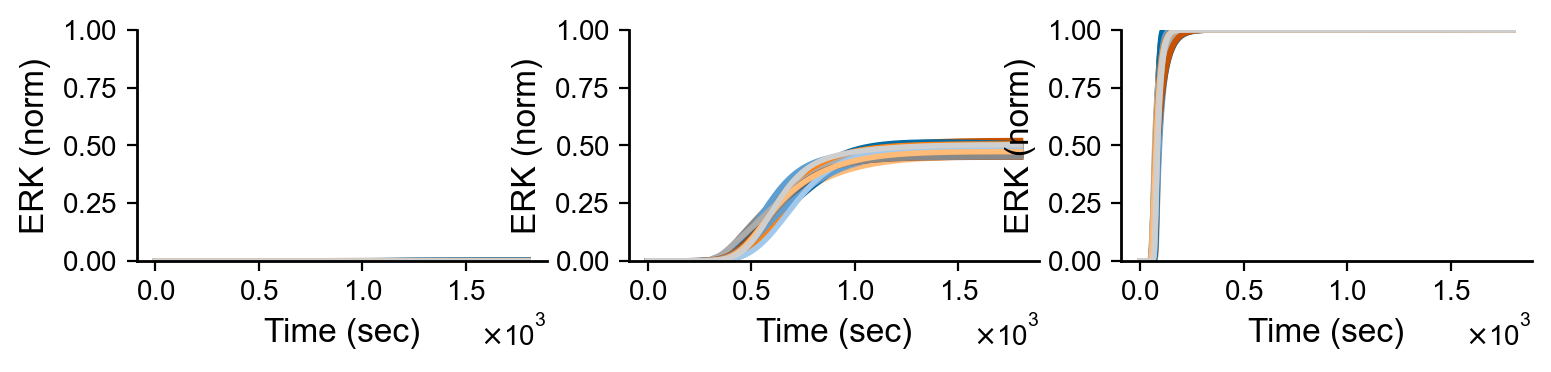

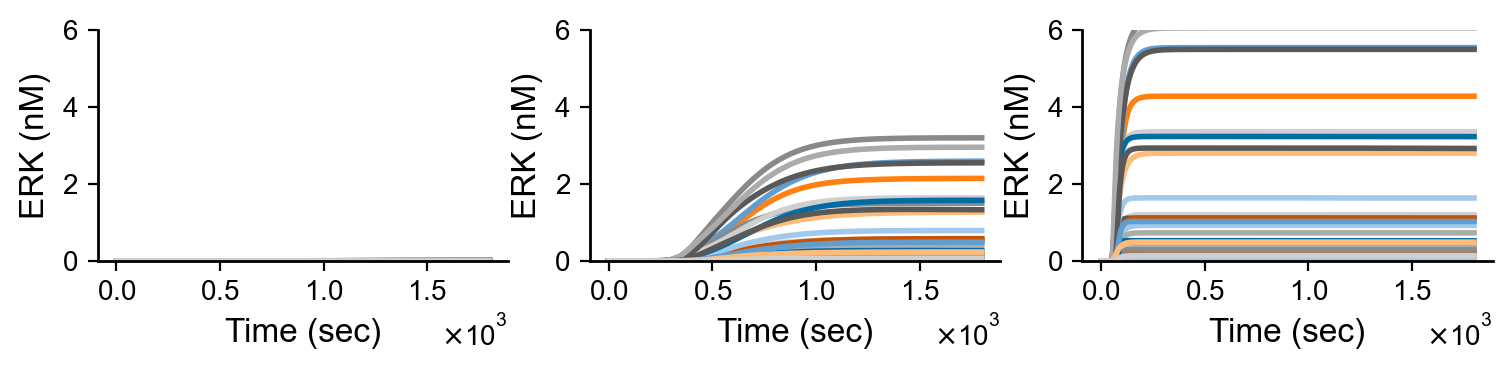

In [9]:
fig0, ax0 = plt.subplots(1,3, figsize=(9, 1.5))
fig1, ax1 = plt.subplots(1,3, figsize=(9, 1.5))

for idx_interest in range(40):
    max_time = 30*60

    traj = ERK_stim_trajectory_set(param_samples_traj[idx_interest], diffrax.ODETerm(model), max_time, y0_EGF_ins[[0,3,9]], ERK_indices, np.linspace(0,max_time,1000))

    for i in range(3):
        ax0[i].plot(np.linspace(0,max_time,1000), traj[0][i], lw=2)
        ax1[i].plot(np.linspace(0,max_time,1000), traj[1][i], lw=2)

for i in range(3):
    ax0[i].set_xlabel('Time (sec)')
    ax0[i].set_ylabel('ERK (norm)')
    ax0[i].set_ylim(0,1)
    # ax0[i].set_yscale('log')

    ax1[i].set_xlabel('Time (sec)')
    ax1[i].set_ylabel('ERK (nM)')
    ax1[i].set_ylim(0,6)
    # ax1[i].set_yscale('log')

In [12]:
def run_ss_checking_analysis(model_name, savedir, nsamples=40):
    print('running:' +model_name)
    info = model_info[model_name]

    idata,_ = load_smc_samples_to_idata('../../results/MAPK/param_est/HF96_synthetic_data/' + model_name + '/' + model_name + '_smc_samples.json')

    model = eval(model_name + '(transient=False)')
    p_dict, _ = model.get_nominal_params()
    print(p_dict)
    y0_dict, y0 = model.get_initial_conditions()

    inputs_native_units = inputs * float(info['EGF_conversion_factor'])
    # get the EGF index and ERK indices
    state_names = list(y0_dict.keys())
    EGF_idx = state_names.index(info['input_state'])
    ERK_indices = [state_names.index(s) for s in info['ERK_states'].split(',')]

    # make initial conditions that reflect the inputs
    y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)

    param_samples = get_param_subsample(idata, nsamples, p_dict)

    if info['max_time'] == 'inf':
        t1 = jnp.inf
        print(info['max_time'])
    else:
        t1 = float(info['max_time'])
        # t1 = jnp.inf

    sols_traj_default = []
    sols_traj_small = []
    for param in param_samples:
        temp_default = []
        temp_small = []
        for input in y0_EGF_ins:
            sol_default, ts = solve_traj_local(diffrax.ODETerm(model), input, param, t1, ERK_indices, event_rtol=1e-6, event_atol=1e-5)
            temp_default.append((sol_default, ts))

            sol_small, ts = solve_traj_local(diffrax.ODETerm(model), input, param, t1, ERK_indices, event_rtol=1e-10, event_atol=1e-10)
            temp_small.append((sol_small, ts))
        sols_traj_default.append(temp_default)
        sols_traj_small.append(temp_small)

    normalized_default = np.squeeze(np.array([np.array([np.array(s[0]) for s in sol]) for sol in sols_traj_default]))
    normalized_small = np.squeeze(np.array([np.array([np.array(s[0]) for s in sol]) for sol in sols_traj_small]))


    fig, ax = plt.subplots(2, 4, figsize=(9, 4))

    # plot dose-response curves
    for sol in normalized_default:
        ax[0,3].plot(inputs, sol/np.max(sol), alpha=0.5,)

    for sol in normalized_small:
        ax[1,3].plot(inputs, sol/np.max(sol), alpha=0.5,)

    ax[0,3].set_xscale('log')
    ax[0,3].set_xlabel('EGF')
    # ax[0,3].set_ylabel('ERK (normalized) \n Default Tolerances')
    ax[1,3].set_xscale('log')
    ax[1,3].set_xlabel('EGF')
    # ax[1,3].set_ylabel('ERK (normalized) \n Small Tolerances')

    for idx_interest in range(nsamples):
        max_time_default = np.max([s[1] for s in np.array(sols_traj_default[idx_interest])[[0,3,9]]])
        max_time_small = np.max([s[1] for s in np.array(sols_traj_small[idx_interest])[[0,3,9]]])

        traj_default = ERK_stim_trajectory_set(param_samples[idx_interest], diffrax.ODETerm(model), max_time_default, y0_EGF_ins[[0,3,9]], ERK_indices, np.linspace(0,max_time_default,1000))
        traj_small = ERK_stim_trajectory_set(param_samples[idx_interest], diffrax.ODETerm(model), max_time_small, y0_EGF_ins[[0,3,9]], ERK_indices, np.linspace(0,max_time_small,1000))

        for i in range(3):
            ax[0,i].plot(np.linspace(0,max_time_default,1000), traj_default[0][i], lw=2, alpha=0.5)
            ax[1,i].plot(np.linspace(0,max_time_small,1000), traj_small[0][i], lw=2, alpha=0.5)
            

        for i in range(3):
            ax[0,i].set_xlabel('Time (sec)')
            ax[0,0].set_ylabel('ERK (normalized) \n Default Tolerances')
            ax[0,i].set_yscale('log')

            ax[1,i].set_xlabel('Time (sec)')
            ax[1,0].set_ylabel('ERK (normalized) \n Small Tolerances')
            ax[1,i].set_yscale('log')

    fig.tight_layout()
    fig.suptitle(model_name)

    fig.savefig(savedir + model_name + '_ss_checking.pdf')
    plt.close(fig)
    

In [13]:
models = list(model_info.keys())
print(models)

for model in models:
    run_ss_checking_analysis(model, '../../results/MAPK/20240205_testing_SS/', nsamples=40)

['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003', 'hornberg_2005', 'birtwistle_2007', 'orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
running:kholodenko_2000
{'v1': 1.0, 'KI': 9.0, 'K1': 10.0, 'n': 1.0, 'v2': 0.25, 'K2': 8.0, 'k3': 0.025, 'K3': 15.0, 'k4': 0.025, 'K4': 15.0, 'v5': 0.75, 'K5': 15.0, 'v6': 0.75, 'K6': 15.0, 'k7': 0.025, 'K7': 15.0, 'k8': 0.025, 'K8': 15.0, 'v9': 0.5, 'K9': 15.0, 'v10': 0.5, 'K10': 15.0, 'MKKK_total': 100.0, 'MKK_total': 300.0, 'MAPK_total': 300.0}
inf
running:levchenko_2000
{'a1': 1.0, 'a2': 0.5, 'a3': 3.3, 'a4': 10.0, 'a5': 3.3, 'a6': 10.0, 'a7': 20.0, 'a8': 5.0, 'a9': 20.0, 'a10': 5.0, 'd1': 0.4, 'd2': 0.5, 'd3': 0.42, 'd4': 0.8, 'd5': 0.4, 'd6': 0.8, 'd7': 0.6, 'd8': 0.4, 'd9': 0.6, 'd10': 0.4, 'k1': 0.1, 'k2': 0.1, 'k3': 0.1, 'k4': 0.1, 'k5': 0.1, 'k6': 0.1, 'k7': 0.1, 'k8': 0.1, 'k9': 0.1, 'k10': 0.1, 'kOn1': 10.0, 'kOn2': 10.0, 'kOff1': 0.05, 'kOff2': 0.05, 'kOff3': 0.05, 'kOff4': 0.5, 'RAFPase': 0.3, 'MEKPase

In [11]:
run_ss_checking_analysis('orton_2009', '../../results/MAPK/20240205_testing_SS/', nsamples=40)

running:orton_2009
{'k1_Sos_Deactivation': 2.5, 'k1_EGF_Binding_Unbinding': 2.18503e-05, 'PP2AActive': 120000.0, 'k2_EGF_Binding_Unbinding': 0.0121008, 'k1_EGFReceptor_Degradation_Free': 0.00125, 'k1_C3G_Deactivation': 2.5, 'k1_EGFReceptor_Degradation': 0.2, 'k1_Akt_Deactivation': 0.005, 'k1_PI3K_Deactivation': 0.005, 'Rap1Gap': 120000.0, 'Kcat_Erk_Activation': 9.85367, 'k1_P90Rsk_Deactivation': 0.005, 'Kcat_Mek_Deactivation': 2.83243, 'Kcat_Mek_Activation': 185.759, 'Kcat_Raf1_Deactivation': 0.126329, 'Kcat_Raf1_Activation': 0.884096, 'Kcat_Ras_Deactivation': 1509.36, 'Kcat_Ras_Activation': 32.344, 'Kcat_Sos_Activation': 694.731, 'kcat_bRaf_Activation_Ras': 0.884096, 'km_bRaf_Activation_Ras': 62464.6, 'kcat_Mek_Activation_bRaf': 185.759, 'kcat_bRaf_Deactivation': 0.126329, 'kcat_bRaf_Activation': 0.884096, 'kcat_Rap1_Deactivation': 1509.36, 'kcat_Rap1_Activation': 32.344, 'kcat_C3G_Activation': 694.731, 'km_Mek_Activation_bRaf': 4768350.0, 'km_bRaf_Deactivation': 1061.71, 'km_bRaf_Act